<a href="https://colab.research.google.com/github/abia200304/Distinct-Vehicle-Flow-Prediction-/blob/main/LSTM_ATTENTION_MECH_pems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -o /content/my_pems_data.zip

Archive:  /content/my_pems_data.zip
   creating: my_pems_data/
  inflating: my_pems_data/pems_station_500011021_flow_04-01-2024_0600_to_04-07-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-08-2024_0600_to_04-14-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-15-2024_0600_to_04-21-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-22-2024_0600_to_04-28-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-29-2024_0600_to_05-05-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-06-2024_0600_to_05-12-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-13-2024_0600_to_05-19-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-20-2024_0600_to_05-26-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-27-2024_0600_to_06-02-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_06-03-2024_0600_to_06-09-202

In [ ]:
from glob import glob
import pandas as pd
import numpy as np

file_paths = glob('/content/my_pems_data/*.csv')
all_data = []

for file in file_paths:
    try:
        df = pd.read_csv(file, delimiter='\t')
        df.columns = df.columns.str.strip()
        if 'Flow (Veh/5 Minutes)' in df.columns and 'Truck Flow (Veh/5 Minutes)' in df.columns:
            all_data.append(df[['Flow (Veh/5 Minutes)', 'Truck Flow (Veh/5 Minutes)']])
        else:
            print(f"Skipping {file}: Required columns not found")
    except Exception as e:
        print(f"Error reading {file}: {e}")


In [ ]:
combined_df = pd.concat(all_data, ignore_index=True)
print(combined_df.shape)

(22824, 2)


In [ ]:
def process_traffic_data(df):

    processed_df = df.copy()

    processed_df = processed_df.rename(columns={
        'Flow (Veh/5 Minutes)': 'total_flow',
        'Truck Flow (Veh/5 Minutes)': 'truck_flow'
    })

    if 'total_flow' not in processed_df.columns or 'truck_flow' not in processed_df.columns:
        print("Error: Renaming of columns failed. Check original column names.")
        return None

    # Calculate Non-Truck Flow = Total Flow - Truck Flow
    processed_df['non_truck_flow'] = processed_df['total_flow'] - processed_df['truck_flow']

    # Handle any negative values
    negative_mask = processed_df['non_truck_flow'] < 0
    if negative_mask.sum() > 0:
        print(f"⚠️ Warning: {negative_mask.sum()} rows have negative non-truck flow values")
        processed_df.loc[negative_mask, 'non_truck_flow'] = 0

    # Add time-based features
    processed_df['time_index'] = range(len(processed_df))

    return processed_df


In [ ]:
processed_df = process_traffic_data(combined_df)


In [ ]:
display(processed_df)
print(processed_df.shape)

,total_flow,truck_flow,non_truck_flow,time_index
0,22.0,0.0,22.0,0
1,27.0,0.0,27.0,1
2,29.0,0.0,29.0,2
3,18.0,0.0,18.0,3
4,14.0,0.0,14.0,4
...,...,...,...,...
22819,23.0,0.0,23.0,22819
22820,48.0,0.0,48.0,22820
22821,25.0,0.0,25.0,22821
22822,29.0,0.0,29.0,22822


(22824, 4)


In [ ]:

processed_df.columns

Index(['total_flow', 'truck_flow', 'non_truck_flow', 'time_index'], dtype='object')

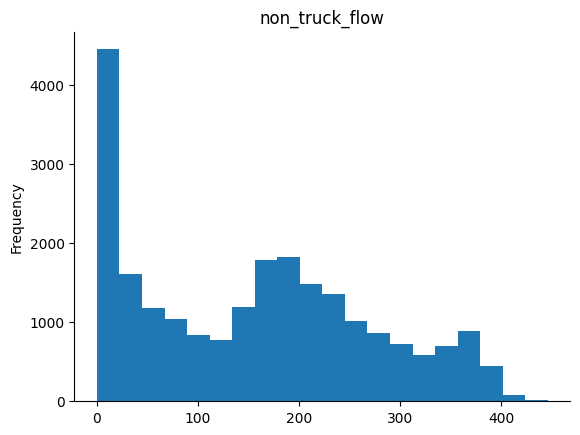

In [ ]:
from matplotlib import pyplot as plt
processed_df['non_truck_flow'].plot(kind='hist', bins=20, title='non_truck_flow')
plt.gca().spines[['top', 'right',]].set_visible(False)

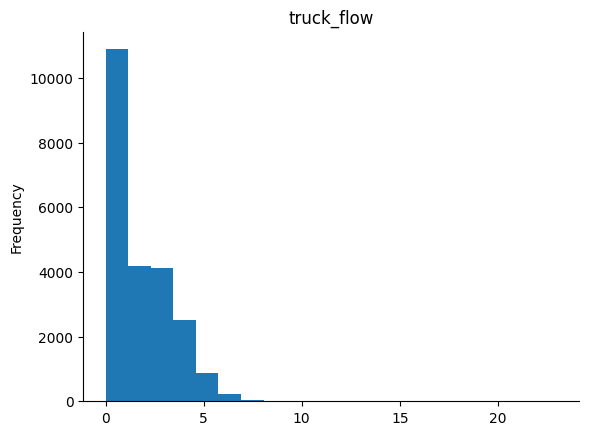

In [ ]:
from matplotlib import pyplot as plt
processed_df['truck_flow'].plot(kind='hist', bins=20, title='truck_flow')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:

column_1_data = processed_df['truck_flow']
column_2_data = processed_df['non_truck_flow']

In [ ]:
coloumn_1_data=np.array(column_1_data)
coloumn_2_data=np.array(column_2_data)

In [ ]:
column1_data=coloumn_1_data.reshape(-1,1)
column2_data =coloumn_2_data.reshape(-1,1)

In [ ]:
data = np.concatenate([ column1_data,column2_data],axis =1)
print(data.shape)

(22824, 2)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scalar=MinMaxScaler((0,1))
scaled_data=scalar.fit_transform(data)

In [ ]:
scaled_data.shape

(22824, 2)

In [ ]:
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)
time_step = 15
X, Y= create_dataset(scaled_data, time_step)
print(X.shape)
print(Y.shape)

(22809, 15, 2)
(22809, 2)


In [ ]:
X_train=X[:int(0.8*len(X))]
y_train = Y[:int(0.8*len(Y))].reshape(-1,2)
X_test = X[int(0.8*len(X)):]
y_test = Y[int(0.8*len(Y)):].reshape(-1,2)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18247, 15, 2)
(18247, 2)
(4562, 15, 2)
(4562, 2)


In [ ]:
from keras import regularizers
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Layer, Dropout
from keras.models import Model
import tensorflow as tf
from keras import regularizers

class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        self.dense_score = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # inputs: (batch, timesteps, features)
        score = self.dense_score(inputs)  # shape: (batch, timesteps, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

input_1 = Input(shape=(15, 1), name='truck_flow')
input_2 = Input(shape=(15, 1), name='non_truck_flow')

# Use return_sequences=True to retain time dimension for attention
lstm_1 = LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))(input_1)
# lstm_1 = Dropout(0.20)(lstm_1)

lstm_2 = LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))(input_2)
# lstm_2 = Dropout(0.20)(lstm_2)

# Concatenate along features (not timesteps)
concat = Concatenate(axis=-1)([lstm_1, lstm_2])  # shape: (batch, 15, 64)

attention_output = AttentionLayer()(concat)


dense = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1))(attention_output)
# dense = Dropout(0.25)(dense)

output = Dense(2, activation='linear',kernel_regularizer=regularizers.l2(0.1))(dense)

model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()
# return model # Assuming you want to create and use the model directly

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ truck_flow          │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ non_truck_flow      │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 15, 32)    │      4,352 │ truck_flow[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 15, 32)    │      4,352 │ non_truck_flow[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 15, 64)    │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 64)        │         65 │ concatenate[0][0] │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,059 (51.01 KB)

 Trainable params: 13,059 (51.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# def create_model():
#     from keras import regularizers
#     from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Layer
#     from keras.models import Model
#     import tensorflow as tf
#     from keras import regularizers

#     class AttentionLayer(Layer):
#         def __init__(self):
#             super(AttentionLayer, self).__init__()
#             # Create the Dense layer in the __init__ method
#             # Adjusted units to match the last dimension of the input
#             self.dense_score = tf.keras.layers.Dense(2)

#         def call(self, inputs):
#             # Compute attention scores using the created Dense layer
#             score = self.dense_score(inputs)
#             attention_weights = tf.nn.softmax(score, axis=1)
#             # Weighted sum
#             context_vector = attention_weights * inputs
#             context_vector = tf.reduce_sum(context_vector, axis=1)
#             return context_vector

#     class ReshapeLayer(Layer):
#         def __init__(self, shape):
#             super(ReshapeLayer, self).__init__()
#             self.shape = shape

#         def call(self, inputs):
#             return tf.reshape(inputs, shape=self.shape)


#     input_1 = Input(shape=(15, 1), name='truck_flow')

#     input_2 = Input(shape=(15, 1), name='non_truck_flow')


#     lstm_1 = LSTM(24, return_sequences=False,kernel_regularizer=regularizers.l2(0.1))(input_1)
#     lstm_2 = LSTM(24, return_sequences=False,kernel_regularizer=regularizers.l2(0.1))(input_2)


#     concat = Concatenate()([lstm_1, lstm_2])
#     print(concat.shape)


#     reshaped_concat = ReshapeLayer(shape=(-1, 24, 2))(concat)
#     print(reshaped_concat.shape)

#     # Apply attention mechanism
#     attention_output = AttentionLayer()(reshaped_concat)

#     output = Dense(2, activation='linear',kernel_regularizer=regularizers.l2(0.01))(attention_output)

#     model = Model(inputs=[input_1, input_2], outputs=output)
#     model.compile(loss='mse', optimizer='adam')
#     model.summary()
#     return model


# model=create_model()




# def create_model():
#     from keras import regularizers
#     from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Layer, Dropout
#     from keras.models import Model
#     import tensorflow as tf

#     class AttentionLayer(Layer):
#         def __init__(self):
#             super(AttentionLayer, self).__init__()
#             self.dense_score = tf.keras.layers.Dense(1)

#         def call(self, inputs):
#             # inputs: (batch, timesteps, features)
#             score = self.dense_score(inputs)  # shape: (batch, timesteps, 1)
#             attention_weights = tf.nn.softmax(score, axis=1)
#             context_vector = attention_weights * inputs
#             context_vector = tf.reduce_sum(context_vector, axis=1)
#             return context_vector

#     input_1 = Input(shape=(15, 1), name='truck_flow')
#     input_2 = Input(shape=(15, 1), name='non_truck_flow')

#     # Use return_sequences=True to retain time dimension for attention
#     lstm_1 = LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))(input_1)
#     lstm_1 = Dropout(0.50)(lstm_1)

#     lstm_2 = LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))(input_2)
#     lstm_2 = Dropout(0.50)(lstm_2)

#     # Concatenate along features (not timesteps)
#     concat = Concatenate(axis=-1)([lstm_1, lstm_2])  # shape: (batch, 15, 64)

#     attention_output = AttentionLayer()(concat)

#     # dense = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(attention_output)
#     # dense = Dropout(0.50)(dense)

#     output = Dense(2, activation='linear')(attention_output)

#     model = Model(inputs=[input_1, input_2], outputs=output)
#     model.compile(loss='mse', optimizer='adam', metrics=['mae'])

#     model.summary()
#     return model

# model = create_model()


In [ ]:

history=model.compile(optimizer='adam', loss='mae')
X1 = X_train[:, :, 0].reshape(-1, 15, 1)  # truck_flow
X2 = X_train[:, :, 1].reshape(-1, 15, 1)  # non_truck_flow

history = model.fit([X1, X2], y_train, epochs=50, validation_split=0.15, verbose=1)


Epoch 1/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 2.6288 - mae: 0.0859 - val_loss: 0.0958 - val_mae: 0.0733
Epoch 2/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0839 - mae: 0.0601 - val_loss: 0.0773 - val_mae: 0.0563
Epoch 3/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0760 - mae: 0.0533 - val_loss: 0.0753 - val_mae: 0.0513
Epoch 4/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0731 - mae: 0.0503 - val_loss: 0.0695 - val_mae: 0.0490
Epoch 5/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0698 - mae: 0.0480 - val_loss: 0.0682 - val_mae: 0.0468
Epoch 6/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0679 - mae: 0.0468 - val_loss: 0.0745 - val_mae: 0.0540
Epoch 7/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0664 - mae: 0.0454 - val_loss: 0.0634 - val_mae: 0.0435
Epoch 8/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0644 - mae: 0.0444 - val_loss: 0.0639 - val_mae: 0.0445
Epoch 9/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 6s 

In [ ]:
model.save('lstm_attention_model.keras')

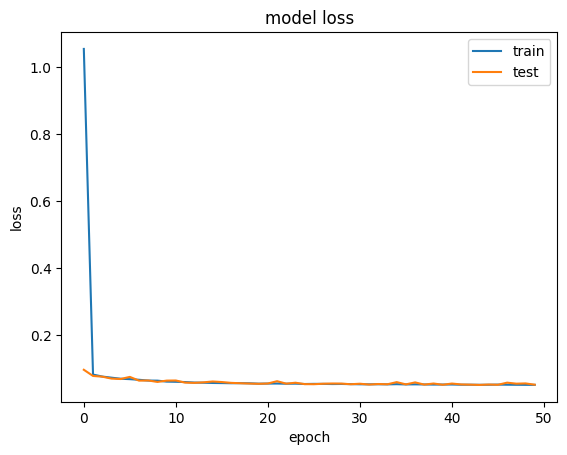

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')


In [ ]:
# Reshape test inputs to match model structure
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
X1_test = X_test[:, :, 0].reshape(-1, 15, 1)
X2_test = X_test[:, :, 1].reshape(-1, 15, 1)

# Predict
y_pred = model.predict([X1_test, X2_test])

# Inverse transform predictions and ground truth
predictions_original_scale = scalar.inverse_transform(y_pred)
y_test_original_scale = scalar.inverse_transform(y_test)


# mae=mean_absolute_error(predictions_original_scale,y_test_original_scale,)
# mse=np.sqrt(mean_squared_error(predictions_original_scale,y_test_original_scale,))
# mape=mean_absolute_percentage_error(predictions_original_scale,y_test_original_scale)
# rmse=np.sqrt(mse)
# print(rmse)
# print(mse)
# print(mae)
# print(mape)


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


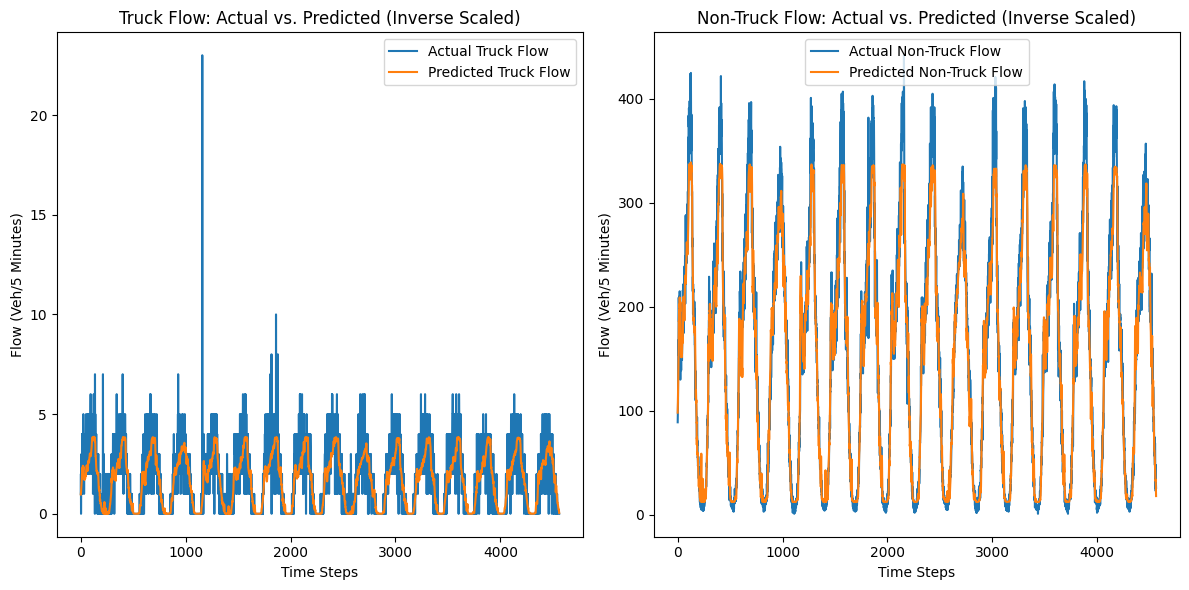

--- Metrics for Truck Flow (Original Scale) ---
RMSE: 1.0410
MAE: 0.6832
MAPE (masked): 38.63%

--- Metrics for Non-Truck Flow (Original Scale) ---
RMSE: 24.5915
MAE: 17.5886
MAPE (masked): 23.70%


In [ ]:

# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 6))

# #  Truck Flow
# plt.subplot(1, 2, 1)
# plt.plot(y_test_original_scale[:, 1], label='Actual Truck Flow')
# plt.plot(predictions_original_scale[:, 1], label='Predicted Truck Flow')
# plt.title('Truck Flow: Actual vs. Predicted (Inverse Scaled)')
# plt.xlabel('Time Steps')
# plt.ylabel('Flow (Veh/5 Minutes)')
# plt.legend()

# # Non-Truck Flow
# plt.subplot(1, 2, 2)
# plt.plot(y_test_original_scale[:, 0] , label='Actual Non-Truck Flow')
# plt.plot(predictions_original_scale[:, 0], label='Predicted Non-Truck Flow')
# plt.title('Non-Truck Flow: Actual vs. Predicted (Inverse Scaled)')
# plt.xlabel('Time Steps')
# plt.ylabel('Flow (Veh/5 Minutes)')
# plt.legend()

# plt.tight_layout()
# plt.show()
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.figure(figsize=(12, 6))

#  Truck Flow
plt.subplot(1, 2, 1)
plt.plot(y_test_original_scale[:, 0], label='Actual Truck Flow')
plt.plot(predictions_original_scale[:, 0], label='Predicted Truck Flow')
plt.title('Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

# Non-Truck Flow
plt.subplot(1, 2, 2)
plt.plot(y_test_original_scale[:, 1], label='Actual Non-Truck Flow')
plt.plot(predictions_original_scale[:, 1], label='Predicted Non-Truck Flow')
plt.title('Non-Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

plt.tight_layout()
plt.show()

# --- Truck Flow ---
actual_truck_flow = y_test_original_scale[:, 0]
predicted_truck_flow = predictions_original_scale[:, 0]

rmse_truck = np.sqrt(mean_squared_error(actual_truck_flow, predicted_truck_flow))
mae_truck = mean_absolute_error(actual_truck_flow, predicted_truck_flow)

# Masked MAPE
mask_truck = actual_truck_flow != 0
mape_truck = np.mean(
    np.abs((actual_truck_flow[mask_truck] - predicted_truck_flow[mask_truck]) / actual_truck_flow[mask_truck])
) * 100

print(f"--- Metrics for Truck Flow (Original Scale) ---")
print(f"RMSE: {rmse_truck:.4f}")
print(f"MAE: {mae_truck:.4f}")
print(f"MAPE (masked): {mape_truck:.2f}%")

# --- Non-Truck Flow ---
actual_non_truck_flow = y_test_original_scale[:, 1]
predicted_non_truck_flow = predictions_original_scale[:, 1]

rmse_non_truck = np.sqrt(mean_squared_error(actual_non_truck_flow, predicted_non_truck_flow))
mae_non_truck = mean_absolute_error(actual_non_truck_flow, predicted_non_truck_flow)

# Masked MAPE
mask_non_truck = actual_non_truck_flow != 0
mape_non_truck = np.mean(
    np.abs((actual_non_truck_flow[mask_non_truck] - predicted_non_truck_flow[mask_non_truck]) / actual_non_truck_flow[mask_non_truck])
) * 100

print(f"\n--- Metrics for Non-Truck Flow (Original Scale) ---")
print(f"RMSE: {rmse_non_truck:.4f}")
print(f"MAE: {mae_non_truck:.4f}")
print(f"MAPE (masked): {mape_non_truck:.2f}%")


In [ ]:
# import tensorflow as tf
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
# converter._experimental_lower_tensor_list_ops = False
# tflite_model = converter.convert()

# # Save to .tflite file
# with open('lstm_attention_model_quant.tflite', 'wb') as f:
#     f.write(tflite_model)

Saved artifact at '/tmp/tmpleribkxu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 15, 1), dtype=tf.float32, name='truck_flow'), TensorSpec(shape=(None, 15, 1), dtype=tf.float32, name='non_truck_flow')]
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133863368161040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133863099616528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133863099614800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133863099615568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133863099615760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133863099616720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133863099618640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133863099617296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133863099619216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133863099617

In [ ]:
# from google.colab import files

# # Download the quantized model
# files.download("lstm_attention_model_quant.tflite")